In [1]:
import numpy as np
import pandas as pd
from data_handling import *
from sklearn import tree

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score,precision_score,f1_score

In [45]:
trading_days = get_trading_days(1)
print(len(trading_days))

380


In [64]:
STEP = 5
pre_date1 = trading_days[0][0]
X = []
Y = []
for i in range(STEP-1,len(trading_days)-STEP,STEP):
    now_index = i
    date1 = trading_days[i][0]
    next_day = trading_days[now_index+STEP][0]
    cur = get_con().cursor()
#     print(pre_date1,date1)
    q_str = f" with unique_b as (select id from bond where trade_dt='{date1}' group by company_name,spread) \
            select b.id,(b.spread-a.spread)*100,b.province,b.city from bond as a, bond as b where a.id=b.id and a.id in unique_b and a.trade_dt='{pre_date1}' and \
            b.trade_dt='{date1}' "
    cur.execute(q_str)
    df = pd.DataFrame(cur.fetchall(),columns=['bond','diff','province','city'])
    count_dict = dict()
    total_dict = dict()
    for i in range(df.shape[0]):
        province_name = df.iloc[i]['province']
        if not pd.isnull(df.iloc[i]['city']):
            city_name = df.iloc[i]['city']
            total_dict[city_name] = total_dict.setdefault(city_name,0) + df.iloc[i]['diff']
            count_dict[city_name] = count_dict.setdefault(city_name,0) + 1
        total_dict[province_name] = total_dict.setdefault(province_name,0) + df.iloc[i]['diff']
        count_dict[province_name] = count_dict.setdefault(province_name,0) + 1
    for i in range(df.shape[0]):
        x=[]
        province_name = df.iloc[i]['province']
        if not pd.isnull(df.iloc[i]['city']) and count_dict[df.iloc[i]['city']]>1:
            city_name = df.iloc[i]['city']
            x.append(round((total_dict[city_name]- df.iloc[i]['diff'])/(count_dict[city_name]-1),5))
        else:
            x.append(0)
        if count_dict[province_name]>1:
            x.append(round((total_dict[province_name]- df.iloc[i]['diff'])/(count_dict[province_name]-1),5))
        else:
            continue
        x.append(round(df.iloc[i]['diff'],5))
        bond_id = df.iloc[i]['bond']
        cur = get_con().cursor()
        cur.execute(f"select (b.spread-a.spread)*100 from bond as a, bond as b where a.id=b.id and a.id='{bond_id}' and \
                    a.trade_dt='{date1}' and b.trade_dt='{next_day}'")
        
        y = cur.fetchall()
        if y:
            X.append(x)
            Y.append(round(y[0][0],5))
    pre_date1 = date1
    print(len(X),len(Y))

2116 2116
4228 4228
6329 6329
8423 8423
10545 10545
12675 12675
14805 14805
16936 16936
19062 19062
21191 21191
23309 23309
25428 25428
27545 27545
29665 29665
31781 31781
33892 33892
36019 36019
38168 38168
40327 40327
42481 42481
44627 44627
46776 46776
48924 48924
50968 50968
53025 53025
54388 54388
55694 55694
56999 56999
58548 58548
60732 60732
60757 60757
60777 60777
60797 60797
62780 62780
64978 64978
67175 67175
69374 69374
71576 71576
73776 73776
75967 75967
78159 78159
80356 80356
82548 82548
84715 84715
86883 86883
89044 89044
91227 91227
93407 93407
95590 95590
97780 97780
99981 99981
102185 102185
104384 104384
105821 105821
107258 107258
108695 108695
110904 110904
113080 113080
115253 115253
117432 117432
119644 119644
121864 121864
124095 124095
126335 126335
128569 128569
130804 130804
133039 133039
135296 135296
137562 137562
139826 139826
142089 142089
144349 144349
146606 146606
148862 148862
150368 150368


In [4]:
def get_label(x):
    if x>5:
        return 1
#     elif x<-5:
#         return 2
    else:
        return 0

In [5]:
# # 保存
# import numpy as np
# Xs=np.array(X)
# np.save('city_province_self_spread_X1.npy',Xs)   # 保存为.npy格式
# Ys=np.array(Y)
# np.save('city_province_self_spread_Y1.npy',Ys) 
# 读取
X=np.load('city_province_self_spread_X1.npy')
Y=np.load('city_province_self_spread_Y1.npy')

In [6]:
THRESHOLD = 5
X_tr,X_te = X[:108695],X[108695:]
Y_tr,Y_te = [get_label(y) for y in Y[:108695]],[get_label(y) for y in Y[108695:]]

In [25]:
def train_trees(X_tr,Y_tr):
    scores = []
    min_scores = []
    for d in range(2,8):
        cls = tree.DecisionTreeClassifier(max_depth=d)
        cls.fit(X_tr,Y_tr)
        evaluate(cls)
#     return scores,min_scores

In [24]:
def evaluate(cls):
        sc=cls.score(X_te,Y_te)
        y_pred = cls.predict(X_te)
        print(sc,precision_score(Y_te,y_pred),recall_score(Y_te,y_pred),f1_score(Y_te,y_pred))

In [67]:
print(tt)

0.1360833153360689


In [72]:
cls = tree.DecisionTreeClassifier(max_depth=3)
cls.fit(X_tr,Y_tr)
sc=cls.score(X_te,Y_te)
print(sc)

0.8709236196098193


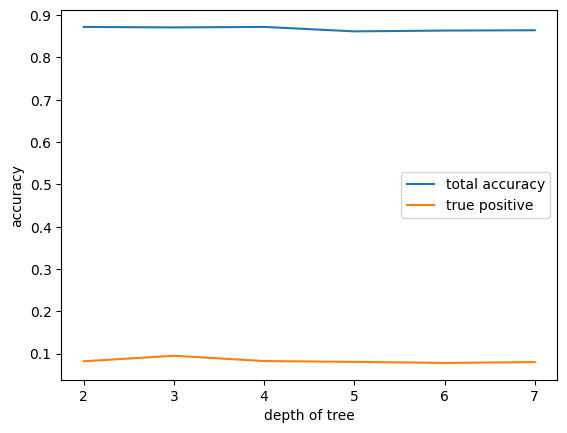

In [47]:
plt.plot(range(2,8),scores,label='total accuracy')
plt.plot(range(2,8),min_scores,label='true positive')
plt.xlabel('depth of tree')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [56]:
from sklearn import linear_model

In [69]:
clf = linear_model.LogisticRegression()
clf.fit(X_tr,Y_tr)
print(clf.score(X_te,Y_te))

0.8639166846639311


In [71]:
print(warn_truth(X_te,Y_te,clf))

(0.001939693175806736, 0.1360833153360689)


平均训练数据

In [7]:
import random

In [10]:
X_tr_avg = []
Y_tr_avg = []
positive_c = 0
negative_c = 0
for i in range(len(X_tr)):
    if Y_tr[i] ==0:
        if random.random()<0.45:
            X_tr_avg.append(X_tr[i])
            Y_tr_avg.append(Y_tr[i])
            negative_c +=1
    else:
        X_tr_avg.append(X_tr[i])
        Y_tr_avg.append(Y_tr[i])
        positive_c +=1
print(positive_c/negative_c)

1.0631977008016942


In [23]:
train_trees(X_tr_avg,Y_tr_avg)

0.8698437837448708 0.6618610747051114 0.0890495503438547 0.15697855144544606
0.8558539102056487 0.37755102040816324 0.09134191500617175 0.14709640778077523
0.8581575600508723 0.41513437057991515 0.10350908129077764 0.16570218772053633
0.8556859357377679 0.3685823754789272 0.08481749250573091 0.137901376146789
0.8383125764883738 0.3126097646645592 0.15693881149709046 0.2089692416060108
0.8389364816547885 0.3153600567577155 0.1567624757538353 0.20942285041224973


In [33]:
for d in range(2,20):
    cls = tree.DecisionTreeClassifier(criterion="entropy",max_depth=d)
    cls.fit(X_tr_avg,Y_tr_avg)
    evaluate(cls)

0.8705876706740575 0.7093373493975904 0.08305413507317934 0.14869771112865035
0.8565977971348355 0.38020424194815394 0.08534649973549638 0.13940092165898618
0.8618529983442517 0.4639865996649916 0.09769000176335743 0.1613983976693372
0.856045881026084 0.3864265927977839 0.09839534473637807 0.15685172171468725
0.8195234324382694 0.26172076249356 0.17915711514724034 0.2127080498272794
0.8533342931874355 0.2814667988107037 0.05007935108446482 0.08502994011976048
0.8378806421423943 0.2974990668159761 0.14053958737436079 0.19089820359281437
0.7880162215343268 0.23915553356424213 0.25568682771997886 0.24714504857678543
0.7530295395099945 0.21895146575842356 0.31740433785928407 0.2591419522027066
0.7614042665514842 0.21842868441866597 0.2921883265737965 0.24998114203816849
0.7842247978307297 0.2310931174089069 0.2516311056251102 0.24092520682086782
0.7510138458954239 0.20277953253316489 0.2830188679245283 0.23627263359340497
0.7510138458954239 0.20553260733508574 0.2895432904249691 0.24040995

In [47]:
cls = tree.DecisionTreeClassifier(criterion="entropy",max_depth=8)
cls.fit(X_tr_avg,Y_tr_avg)
evaluate(cls)

0.8390084707124517 0.31072210065645517 0.15023805325339445 0.20254368239629145


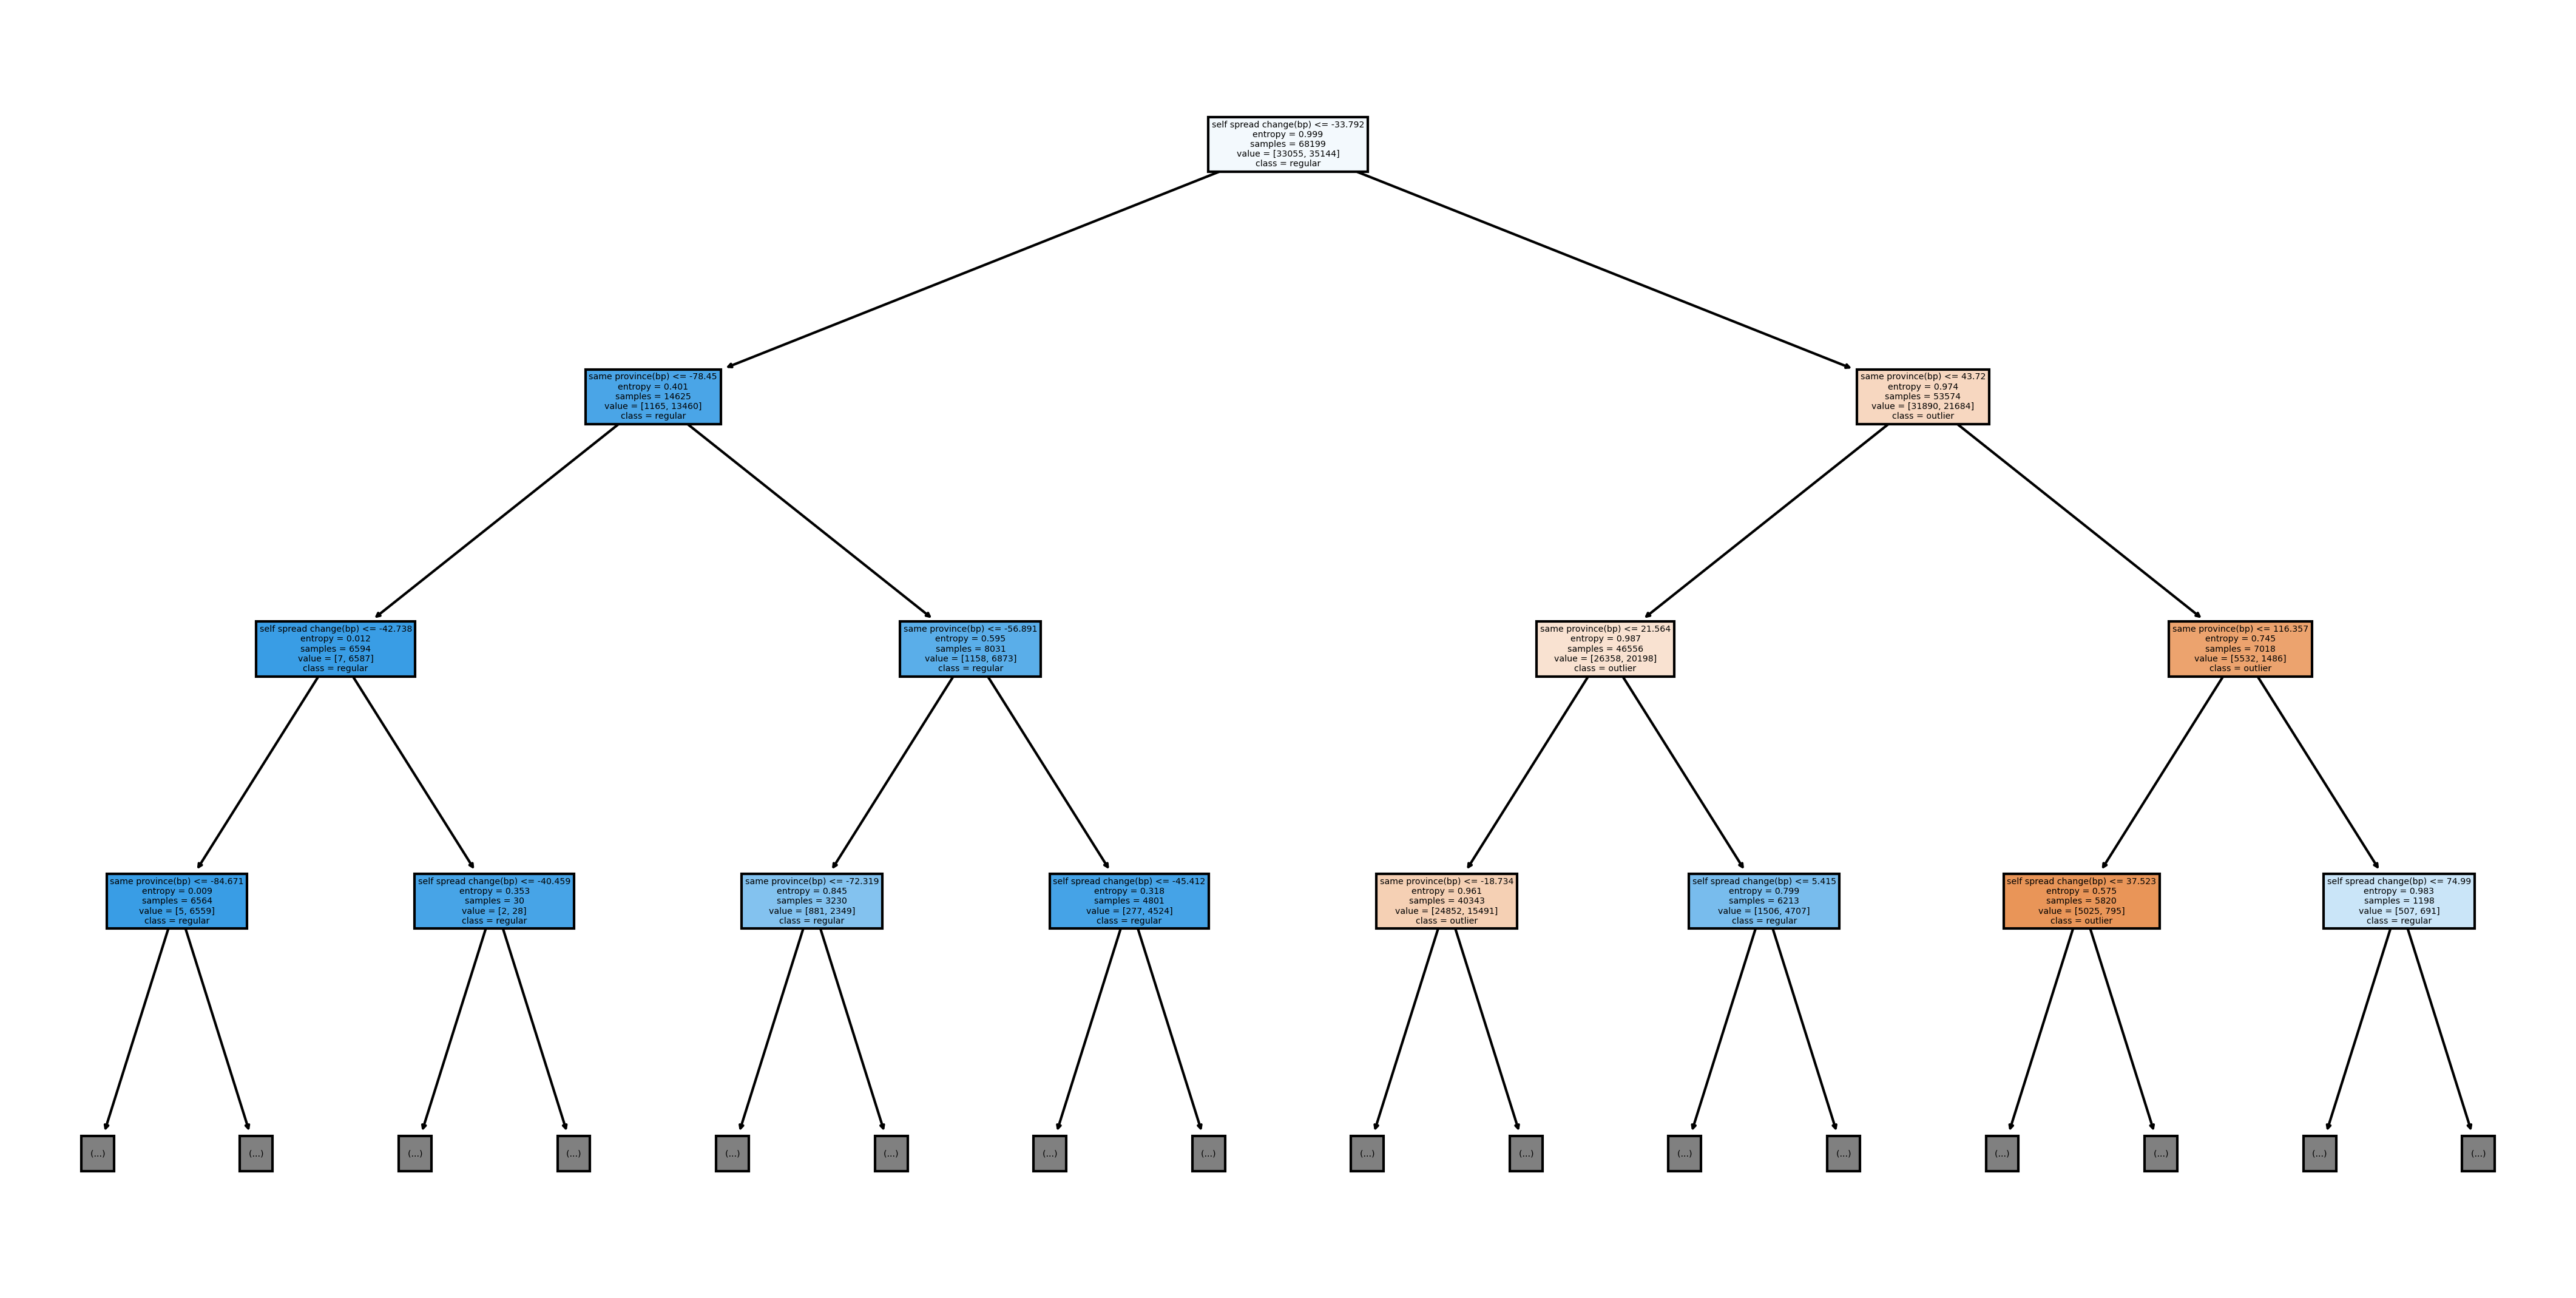

In [44]:
plt.figure(figsize=(18,9),dpi=300)
tree.plot_tree(cls,filled=True,class_names=['outlier','regular'],feature_names=['same city(bp)','same province(bp)','self spread change(bp)'],max_depth=3)
plt.savefig('./model1.jpg')